# Clustering del dataset Iris con l'algoritmo K-means tramite Spark

Ripeteremo la procedura di clustering del data set Iris tramite Spark. Per simulare l'acquisizione da uno storage e non riutilizzare sci-kit learn, acquisiremo il [data set](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/iris.scale) dal repository della libreria [LibSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/index.html) anche perché il formato `libsvm` è uno di quelli riconosciuti dal dataframe reader di Spark.

Inizializziamo dapprima la nostra applicazione:

In [1]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName("K-means clustering of Iris data set in Spark") \
    .getOrCreate()

23/04/05 16:27:00 WARN Utils: Your hostname, deeplearning resolves to a loopback address: 127.0.1.1; using 147.163.26.113 instead (on interface enp6s0)
23/04/05 16:27:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/05 16:27:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/05 16:27:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Acquisiamo il dataframe dal flusso HTTP.

In [2]:
from pyspark import SparkFiles

data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/iris.scale"

# aggiungiamo allo SparkContext l'URL del nostro flusso dati
spark.sparkContext.addFile(data_url)

# possiamo usare direttamente il metodo read() su una copia locale dell'URL
irisdf = spark.read.format("libsvm")\
    .option('numFeatures','4')\
    .load("file://"+SparkFiles.get('iris.scale'))

# mostriamo il dataframe e il suo schema
irisdf.show()

print(irisdf.collect()[0])

irisdf.schema.fields


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,2,3],[-0.77...|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-1....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
|  1.0|(4,[0,1,2,3],[-0....|
+-----+--------------------+
only showing top 20 rows

Row(label=1.0, features=SparseVector(4, {0: -0.5556, 1: 0.25, 2: -0.8644, 3: -0.9167}))


[StructField('label', DoubleType(), True),
 StructField('features', VectorUDT(), True)]

Lo schema non è ancora adatto ai nostri scopi perché le etichette sono dei float e ne facciamo il cast ad intero. Il tipo Vector dei dati, nel nostro caso SparseVector, è invece adatto all'uso degli algoritmi di ML in Spark.

In [3]:
# eseguiamo il cast della colonna 'label'
irisdf=irisdf.withColumn('label',irisdf['label'].cast('integer'))

irisdf.show()

print(irisdf.collect()[0])

irisdf.schema.fields



+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,2,3],[-0.77...|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-1....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
|    1|(4,[0,1,2,3],[-0....|
+-----+--------------------+
only showing top 20 rows

Row(label=1, features=SparseVector(4, {0: -0.5556, 1: 0.25, 2: -0.8644, 3: -0.9167}))


[StructField('label', IntegerType(), True),
 StructField('features', VectorUDT(), True)]

## Breve introduzione sulla libreria `ml` di Spark

La libreria `ml` lavora sui DataFrame, mentre la libreria `mllib` è la controparte sui RDD. La libreria `ml` fornisce l'accesso a diverse classi per la gestione della feature selection, dei modelli veri e propri, la ricerca degli iperparametri e la valutazione dei modelli.

Un'altra caratteristica di `ml` è i lconcetto di _pipeline di machine learning_. Una pipeline è una sequenza ordinata di:

- `Transformer`: algoritmi che trasformano effettivamente un dataframe cpon il metodo `transform()`
- `Estimator` algoritmi che si addestrano sui dati per generare un `Transformer` con il metodo `fit()` che usa la _eager execution_ ovvero l'esecuzione immediata
- `Evaluator`: algoritmi di calcolo dei criteri di valutazione delle performance

Un modello di machine learning è un `Estimator` che, opportunamente parametrizzato e addestrato, genera un `Transformer` cioè il modello che trasforma feature in predizioni. Sono `Transformer` anche gli algoritmi di gestione delle feature in ingresso e uscita.

Infine la `Pipeline` si costruisce assemblando i diversi stadi del processo e può contenere anche algoritmi per il tuning degli iperparametri, attraverso la costruzione di una griglia di ricerca (`ParamGridBuilder`) ovvero la cross-validation (`CrossValidator`).

## Analisi PCA del data set
Eseguiremo adesso l'analisi PCA per individuare il numero di dimensioni sufficiente ad assicurarci un buon clustering.

In [4]:
# importiamo la classe PCA e la ParamGridBuilder per utilizzare diversi valori di troncamento k
from pyspark.ml.feature import PCA
from pyspark.ml.tuning import ParamGridBuilder

# Creiamo un dataframe con ii soli campioni da analizzare, senza le label
#data = irisdf.drop('label')

# Creiamo il modello PCA (Estimator)
pca = PCA(inputCol='features')

# Costruiamo la lista degli iperparametri k da provare
k_values = ParamGridBuilder().addGrid(pca.k,[2, 3, 4]).build() 

# Costruiamo una lista dei modelli multipli generati al variare di k
# questi sono Transformer
models = list(pca.fitMultiple(irisdf,k_values))

    

23/04/05 16:41:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/04/05 16:41:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [5]:
models

[(0, PCAModel: uid=PCA_7b62c4ed24c5, k=2),
 (1, PCAModel: uid=PCA_7b62c4ed24c5, k=3),
 (2, PCAModel: uid=PCA_7b62c4ed24c5, k=4)]

In [8]:
# Generiamo i data set trasformati con la PCA al variare di k
transformed_df = []

for model in models:
    model[1].setOutputCol("output")
    transformed_df.append(model[1].transform(irisdf))
    print(transformed_df[-1].collect()[0].output)

[1.3981560820639132,-0.05812243525603352]
[1.3981560820639132,-0.05812243525603352,0.020025868517133616]
[1.3981560820639132,-0.05812243525603352,0.020025868517133616,0.0007981050882169827]


In [9]:
import numpy as np

#Calcoliamo la varianza totale dei tre data set trasformati e decidiamo quante componeneit principali utilizzare
for model in models:
    print(f'Varianza totale per {model[1].getK()} dimensioni: {np.sum(model[1].explainedVariance.toArray())}')

Varianza totale per 2 dimensioni: 0.9587437460336625
Varianza totale per 3 dimensioni: 0.9936493936513788
Varianza totale per 4 dimensioni: 1.0


Risulta chiaro, come nell'esempio precedente, che è sufficiente lavorare sul data set a due dimensioni. Procederemo all'utilizzo del KMeans con quest'ultimo.

Cominceremo con l'applpicazione dell'Elbow method per determinare il numero di cluster.

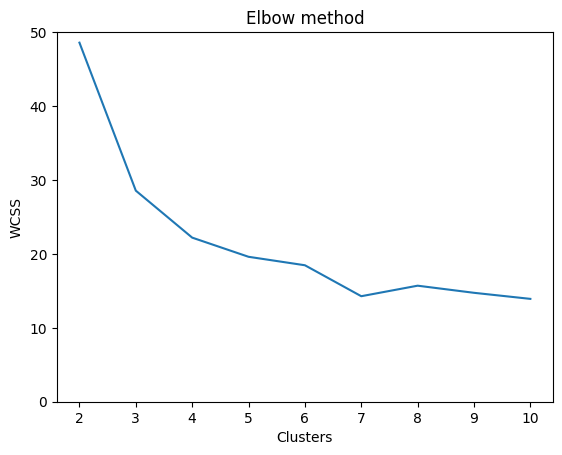

In [10]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as pl

# Creaiamo un array di valori di wcss
wcss = np.zeros(9)

# Creiamo il modello:
# Inizializzazione 'kmeans++' versione parallela, 300 iterazioni per il calcolo dei centroidi
# seme di inizializzazione random pari a 1 e colonna delle predizioni di nome 'cluster'
kmeans = KMeans()\
        .setFeaturesCol('features')\
        .setInitMode('k-means||')\
        .setMaxIter(500)\
        .setSeed(30)\
        .setPredictionCol('cluster')

# Costruiamo la lista dei valori di k da provare
k_values = ParamGridBuilder().addGrid(kmeans.k,[2, 3, 4, 5, 6, 7, 8, 9, 10]).build()

# Creiamo la lista dei modelli al variare 
k_models = list(kmeans.fitMultiple(transformed_df[0],k_values))

# il trainingCost contiene esattamente la WCSS per ogni modello di cui è stato fatto il fit
for k in range(9):
    wcss[k]=k_models[k][1].summary.trainingCost

# Facciamo il plot del grafico
pl.plot([2,3,4,5,6,7,8,9,10],wcss)
pl.ylim(0,50)
pl.xlabel('Clusters')
pl.ylabel('WCSS')
pl.title('Elbow method')
pl.show()

Come verificato in precedenza, il modello migliore è quello con 3 cluster e lo useremo per predire il clustering dei nostri dati.

In [11]:
best_model = k_models[1][1]

predictions = best_model.transform(transformed_df[0])


Si può verificare per ispezione diretta sui dataframe `predictions` e `irisdf` invocando banalmente:

```python
predictions.collect()[_:_]
irisdf.collect()[_:_]
````

su segmenti analoghi dei due dataframe, che sussiste la seguente corrispondenza tra la colonna `label` di `irisdf` e la colonna `cluster` di `predictions`:

- `label = 1` corrisponde a `cluster = 0`
- `label = 2` corrisponde a `cluster = 2`
- `label = 3` corrisponde a `cluster = 1`

Per cui procediamo a un remap delle etichette prima di creare una matrice di confusione.

In [12]:
predictions = predictions.withColumnRenamed('cluster','original_cluster')

predictions=predictions.withColumn('cluster',when(predictions.original_cluster == 0,1).\
                        when(predictions.original_cluster== 2,2).\
                        otherwise(3))

predictions.schema

StructType([StructField('label', IntegerType(), True), StructField('features', VectorUDT(), True), StructField('output', VectorUDT(), True), StructField('original_cluster', IntegerType(), False), StructField('cluster', IntegerType(), False)])

In [13]:
predictions.show(70)

+-----+--------------------+--------------------+----------------+-------+
|label|            features|              output|original_cluster|cluster|
+-----+--------------------+--------------------+----------------+-------+
|    1|(4,[0,1,2,3],[-0....|[1.39815608206391...|               0|      1|
|    1|(4,[0,1,2,3],[-0....|[1.38452609435504...|               0|      1|
|    1|(4,[0,2,3],[-0.77...|[1.47701888820606...|               0|      1|
|    1|(4,[0,1,2,3],[-0....|[1.44669890065234...|               0|      1|
|    1|(4,[0,1,2,3],[-0....|[1.43395982931108...|               0|      1|
|    1|(4,[0,1,2,3],[-0....|[1.20554713198149...|               0|      1|
|    1|(4,[0,1,2,3],[-0....|[1.45022462287372...|               0|      1|
|    1|(4,[0,1,2,3],[-0....|[1.38872088090427...|               0|      1|
|    1|(4,[0,1,2,3],[-0....|[1.49048486809967...|               0|      1|
|    1|(4,[0,1,2,3],[-0....|[1.42970722641363...|               0|      1|
|    1|(4,[0,1,2,3],[-0..

In [14]:
from pyspark.mllib.evaluation import MulticlassMetrics

# selezioniamo le due colonne di predizione ed etichetta per creare un dataframe
# ad hoc in cui questi valori sono di tipo double
preds = predictions.selectExpr('CAST(cluster AS DOUBLE)','CAST(label AS DOUBLE)')

# usiamo la classe MulticlassMetrics di mllib per estrarre la matrice di confusione
# e latrasformiamo in un numpy array
metrics = MulticlassMetrics(preds.rdd)

cf = metrics.confusionMatrix().toArray()


/home/rpirrone/virtualenvs/hadoop/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


A questo punto seguiamo l'altra esercitazione per mostrare graficamente i nostri risultati

In [15]:
cf

array([[50.,  0.,  0.],
       [ 0., 40., 10.],
       [ 0.,  8., 42.]])

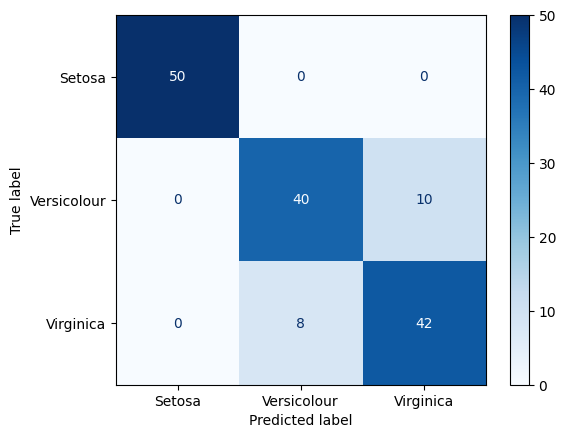

In [16]:
# importiamo i package di sci-kit learn per visualizzare la matrice di confusione e poi calcoliamo gli indici
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# selezioniamo le singole colonne creandi due dataframe di cui facciamoil collect
# per materializzare i dati in un unico iteratore e costruiamo l'array numpy
# facendo il reshape alla fine perché la creazione della matrice di confusione richiede 
# una shape (N,) mentre il collect fornisce un array di righe la cui shape è (N,1)
label = np.array(preds.select('label').collect()).reshape(-1)
cluster = np.array(preds.select('cluster').collect()).reshape(-1)

ConfusionMatrixDisplay.from_predictions(label, cluster, display_labels=np.array(['Setosa','Versicolour','Virginica']),cmap=plt.cm.Blues)

In [17]:
# Calcoliamo le metriche di purity e gini index
def cluster_metrics(cm):
    """Calcolo della purity e dell'indice di Gini da una matrice di confusione

    Args:
        cm (ndarray): matrice di confusione

    Returns:
        tuple[float,float]: i due valori di metrica
    """

    Mval = [np.sum(cm[:,i]) for i in range(cm.shape[1])]
    
    M = np.array(Mval)

    Pval = [np.max(cm[:,i]) for i in range(cm.shape[1])]

    P = np.array(Pval)

    purity = np.sum(P)/np.sum(M)
    
    gini_val = [np.sum((cm[i,:]/M[i])**2) for i in range(cm.shape[0])]

    gini_j = 1 - np.array(gini_val)
    
    gini = np.dot(gini_j, M)/np.sum(M)
    
    return purity, gini

purity, gini = cluster_metrics(cf)

print(f'Purity: {purity:5.2f}\nGini Index: {gini:5.2f}\n')

Purity:  0.88
Gini Index:  0.20

